### Module installation

In [ ]:
!pip install openai==0.28
!pip install tqdm pandas
!pip install transformers sentencepiece optimum
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
from tqdm import tqdm
import openai
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Openai API key setting
openai.api_key = 'sk-'

In [ ]:
# 파일 경로 설정= df
file_path = '/content/drive/MyDrive/Kwargs/esg보고서/concated_label_1.csv'  # 데이터셋 경로를 지정해주세요.
df = pd.read_csv(file_path)

### text pretreatment

In [ ]:
import pandas as pd
import re

# Remove the coaching value
df = df.dropna(subset=['문장'])

# Unnecessary text removal function
def clean_text(text):
    text = re.sub(r'[·•]', '', text)  # 특수 문자 제거
    text = re.sub(r'\s+', ' ', text).strip()  # 연속된 공백 제거 및 양 끝 공백 제거
    return text

# Text summary
df['Cleaned_Sentence'] = df['문장'].apply(clean_text)

# Excessive short content removal (e.g. less than 10 characters)
df = df[df['Cleaned_Sentence'].apply(len) > 10]

# Comparison of the number of sentences before and after pretreatment and the average length
original_sentence_count = df['문장'].count()
processed_sentence_count = len(df)

df['Original_Length'] = df['문장'].apply(len)
original_average_length = df['Original_Length'].mean()

df['Processed_Length'] = df['Cleaned_Sentence'].apply(len)
processed_average_length = df['Processed_Length'].mean()

print(f"Original sentence count: {original_sentence_count}")
print(f"Processed sentence count: {processed_sentence_count}")
print(f"Original average sentence length: {original_average_length:.2f} characters")
print(f"Processed average sentence length: {processed_average_length:.2f} characters")



Original sentence count: 290366
Processed sentence count: 290366
Original average sentence length: 151.67 characters
Processed average sentence length: 150.62 characters


<ipython-input-18-aa12c8c96e77>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Original_Length'] = df['문장'].apply(len)


Original sentence count: 277493
Processed sentence count: 277493
Original average sentence length: 108.37 characters
Processed average sentence length: 107.96 characters


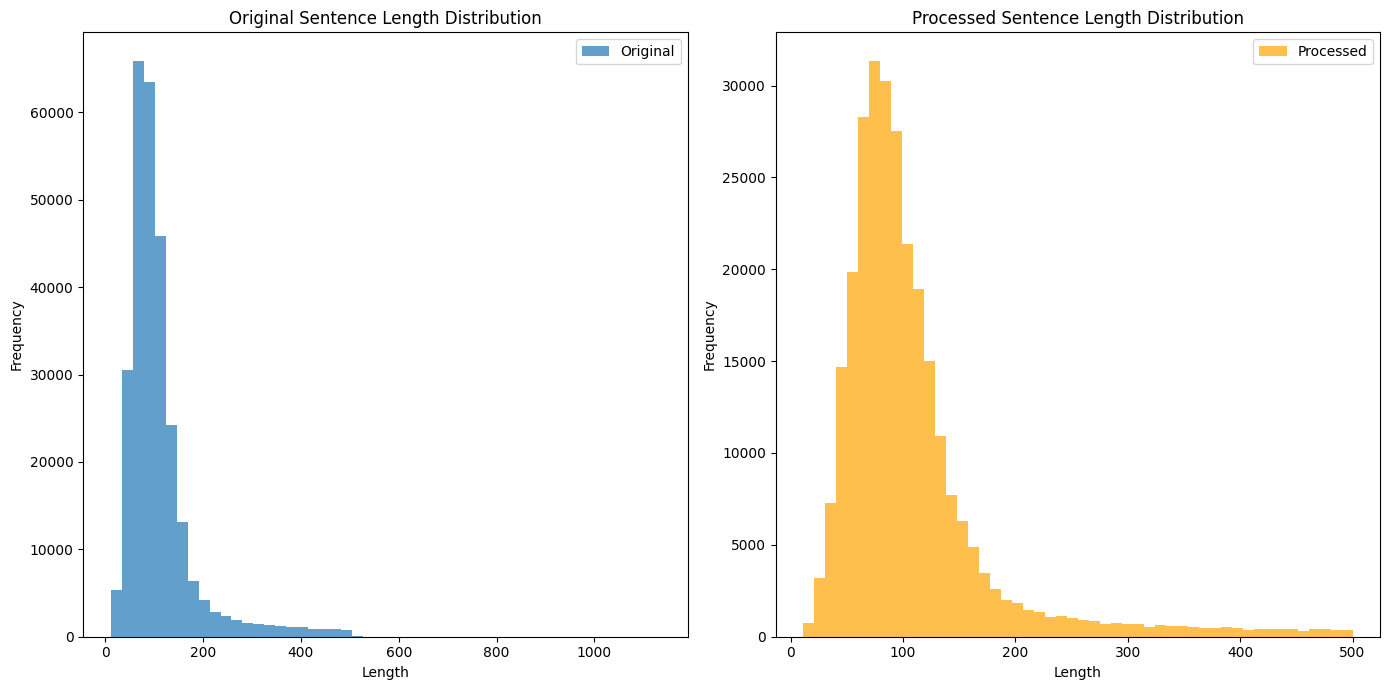

In [ ]:
import re
import matplotlib.pyplot as plt

df['Positive_Sentence'] = df['문장']
# Remove the coaching value
df = df.dropna(subset=['Positive_Sentence'])

# Unnecessary text removal function
def clean_text(text):
    text = re.sub(r'[·•]', '', text)  # 특수 문자 제거
    text = re.sub(r'\s+', ' ', text).strip()  # 연속된 공백 제거 및 양 끝 공백 제거
    return text

# Text summary
df['Cleaned_Sentence'] = df['Positive_Sentence'].apply(clean_text)

# Excessive short content removal (e.g. less than 10 characters)
df = df[df['Cleaned_Sentence'].apply(len) > 10]

#County length calculation
df['Original_Length'] = df['Positive_Sentence'].apply(len)
df['Processed_Length'] = df['Cleaned_Sentence'].apply(len)

# Unusually long sentence filtering (for example, more than 500 characters)
df = df[df['Processed_Length'] <= 500]

# Comparison of the number of sentences before and after pretreatment and the average length
original_sentence_count = df['Positive_Sentence'].count()
processed_sentence_count = len(df)

original_average_length = df['Original_Length'].mean()
processed_average_length = df['Processed_Length'].mean()

print(f"Original sentence count: {original_sentence_count}")
print(f"Processed sentence count: {processed_sentence_count}")
print(f"Original average sentence length: {original_average_length:.2f} characters")
print(f"Processed average sentence length: {processed_average_length:.2f} characters")

# Distribution visualization
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(df['Original_Length'], bins=50, alpha=0.7, label='Original')
plt.title('Original Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df['Processed_Length'], bins=50, alpha=0.7, color='orange', label='Processed')
plt.title('Processed Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
df['Cleaned_Sentence'].sample(50)

238458    육아휴직, 출산휴가로 인한 평가 불이익 발생을 예방하기 위해 장기간 휴직휴가로 평가...
186662    이때 발생된 CO₂를 저감하기 위한 CO₂ Capture 기 술은 석탄화력발전과 산...
20402     물리적리스크로 인한 태풍홍수 피해규모의 경우 2050년 기준 무정책 시나리오에서 약...
229624    글로벌 품질시스템 인증 금호타이어는 고객과의 신뢰성 강화와 더불어 신뢰받는 기업이 ...
16463     컴 플 라 이 언 스 관 리 프 로 세 스 사 전 예 방 : 컴 플 라 이 언 스 ...
59341     재생에너 지 통합관제시스템을 통해 재생에너지 발전출력과 전기품질을 실 시간 모니터링...
245975    또한 판매 직원을 대상으로 ‘POS 역량 랜덤평가’를 실시하여 판매 직 원들이 PO...
240618    ESG Infra 구축 3 한전KPS는 2021년 11월 ESG 비전 및 전략목표를...
181273    이후 2023년 북미 CONEXPO 전시회에서도 다양한 고객들의 목소리를 들을 수 ...
40131     해당 정책은 회사가 소유 혹은 보유하거나 회사로부터 생성된 모든 유무형 자산을 대상...
54664     기존 메일로 진행하던 승인 절차를 2022년에는 컴플라이언스 포털을 구축하여 시스템...
43395     그 일환으로 버려지는 폐가전 등에서 새로운 자원을 뽑아내 신제품 외관이나 부품 등에...
262132    외감법 제8조5항에 의거 회사의 감사위원은 내부회계관리제도의 운영 실태를 평가하여 ...
57767     특히, 새로운 비즈니스 모델 창출을 지원하기 위해 고객 계약전력 통계자료 제공 등 ...
54739     에너지 조달 친환경, 저탄소 에너지원에 대한 정책 지원 기후변화 대응을 위한 정부 ...
15397     해외 카 셰어링 서비스 ‘WiBLE’은 2020년 2월 스페인 최대 카헤이링 업 체...
198816    JB금융그룹은 안전보건관리계획을 기반으로 산업재해 관련

### Combined (completed)

In [ ]:
# File path
base_path_label_1 = '/content/drive/MyDrive/Kwargs/esg보고서/라벨링/'

# Import the file list
files_label_1 = [os.path.join(base_path_label_1, f) for f in os.listdir(base_path_label_1) if f.endswith('.csv')]

# Read Label 1 Data
data_label_1 = []
for file in tqdm(files_label_1, desc="Processing label 1 files"):
    df = pd.read_csv(file)
    df['label'] = 1
    df.rename(columns={'sentence': 'text'}, inplace=True)
    data_label_1.append(df)
df_label_1 = pd.concat(data_label_1, ignore_index=True)
df_label_1.to_csv('/content/drive/MyDrive/Kwargs/esg보고서/concated_label_1.csv', index=False)

Processing label 1 files:   9%|▊         | 13/150 [00:01<00:12, 11.36it/s]


KeyboardInterrupt: 

### Test 1: Convert
 Because Korean sentences consume large tokens, to solve this problem, conversion through English is consumed.
 Efficient.

In [ ]:
# Function that converts positive sentences into negative sentences
def paraphrase_positive_to_negative(sentence):
    messages = [
        {"role": "system", "content": "You are a World class Profressional ESG Expert."},
        {"role": "user", "content": f"Paraphrase the following positive sentence about ESG into a negative tone. output must always in korean.: \"{sentence}\""}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=60
    )

    negative_sentence = response['choices'][0]['message']['content'].strip()
    return negative_sentence

# Extracting 5 random sentences
sample_sentences = df['문장'].sample(5, random_state=42)

# Output by converting positive sentences to negative sentences
for sentence in sample_sentences:
    negative_sentence = paraphrase_positive_to_negative(sentence)
    print(f"Positive: {sentence}")
    print(f"Negative: {negative_sentence}")
    print("-" * 50)

Positive: • GRI Standards 보고 원칙 • 공통 표준(Universal Standards) • 특정주제 표준(Topic Specific Standards) - 하기 특정주제표준 경영접근방식(Management approach of Topic Specific Standards) - GRI 201: 경제성과(Economic Performance) - GRI 301: 원재료(Materials) - GRI 305: 배출(Emissions) - GRI 413: 지역사회(Local Communities) - GRI 414: 공급업체 사회평가(Supplier Social Assessment) - GRI 416: 고객 안전 보건(Customer Health and Safety) 보고서의 보고경계 중 조직 외부 즉, 대상㈜의 협력사, 계약자 등에 대한 데이터와 정보는 검증범위에서 제외되었습니다.
Negative: • GRI 표준 보고 의무 • 공통 표준(Universal Standards) • 특정주제 표준(Topic Specific Standards) - 하기 특정주제표준 경영접
--------------------------------------------------
Positive: 특히 취약계층 주거지역에서의 이동이 용이하도록 기아 자동차의 경차 ‘레이’를 지원하며, 여기에는 휠체어 리프트를 장착된 장애인용 특수개조차량이 포함됩 니다.
Negative: "특히 취약계층 주거지역에서의 이동이 불편한 상호 운영 여부 검토 필요성이 개선할 필요가 있는 기아 자동
--------------------------------------------------
Positive: 사후처리보다는 폐수 배출원 중심으로 관리하여 폐수 발생 최소화에 힘쓰고 있습니다 세차시설, 도장시설에서 주로 발생하는 폐수는 도장 폐수의 특성상 처리수의 수질을 철저하게 관리하기 위해 월 1회 오염도 측정 및 주기적 점검을 통해 환경오염 리스크를 줄이고 있습니다.
Negative: 사후 처리

### 2. Reverse conversion method test

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

In [ ]:

model_name_ko_to_en = 't5-base'  # 사용할 모델 이름
tokenizer_ko_to_en = T5Tokenizer.from_pretrained(model_name_ko_to_en)
model_ko_to_en = T5ForConditionalGeneration.from_pretrained(model_name_ko_to_en)

model_name_en_to_ko = 't5-base'  # 사용할 모델 이름
tokenizer_en_to_ko = T5Tokenizer.from_pretrained(model_name_en_to_ko)
model_en_to_ko = T5ForConditionalGeneration.from_pretrained(model_name_en_to_ko)

def translate_ko_to_en(text):
# Translated from Korean to English
    translated = model_ko_to_en.generate(**tokenizer_ko_to_en(text, return_tensors="pt", padding=True))
    translated_text = [tokenizer_ko_to_en.decode(t, skip_special_tokens=True) for t in translated]
    return translated_text[0]

def translate_en_to_ko(text):
# Translated from English to Korean
    translated = model_en_to_ko.generate(**tokenizer_en_to_ko(text, return_tensors="pt", padding=True))
    translated_text = [tokenizer_en_to_ko.decode(t, skip_special_tokens=True) for t in translated]
    return translated_text[0]

# Function that converts positive sentences into negative sentences
def paraphrase_positive_to_negative(sentence):
    english_sentence = translate_ko_to_en(sentence)

    messages = [
        {"role": "system", "content": "You are a World class Profressional ESG Expert."},
        {"role": "user", "content": f"Paraphrase the following positive sentence about ESG into a negative tone. output must always in korean.: \"{sentence}\""}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=100
    )

    negative_sentence = response['choices'][0]['message']['content'].strip()
    korean_sentence = translate_en_to_ko(negative_sentence)
    return english_sentence, negative_sentence, korean_sentence

# Extracting 5 random sentences
sample_sentences = df['문장'].sample(5, random_state=42)

# List to store results
results = []

# Output by converting positive sentences to negative sentences
for sentence in sample_sentences:
    english_sentence, negative_english_sentence, korean_sentence = paraphrase_positive_to_negative(sentence)
    print(f"Original (Korean): {sentence}")
    print(f"Translated to English: {english_sentence}")
    print(f"Negative Sentence (English): {negative_english_sentence}")
    print(f"Back to Korean: {korean_sentence}")
    print("-" * 50)

# Add the result to the list
    results.append({
        "Original (Korean)": sentence,
        "Translated to English": english_sentence,
        "Negative Sentence (English)": negative_english_sentence,
        "Back to Korean": korean_sentence
    })

# Convert the result to data frame
results_df = pd.DataFrame(results)
results_df.sample(5)

#Save the result as a CSV file
# output_file_path = '/content/drive/MyDrive/negative_sentences_dataset.csv'
# results_df.to_csv(output_file_path, index=False)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original (Korean): • GRI Standards 보고 원칙 • 공통 표준(Universal Standards) • 특정주제 표준(Topic Specific Standards) - 하기 특정주제표준 경영접근방식(Management approach of Topic Specific Standards) - GRI 201: 경제성과(Economic Performance) - GRI 301: 원재료(Materials) - GRI 305: 배출(Emissions) - GRI 413: 지역사회(Local Communities) - GRI 414: 공급업체 사회평가(Supplier Social Assessment) - GRI 416: 고객 안전 보건(Customer Health and Safety) 보고서의 보고경계 중 조직 외부 즉, 대상㈜의 협력사, 계약자 등에 대한 데이터와 정보는 검증범위에서 제외되었습니다.
Translated to English: 301: (Materials) - GRI 305:
Negative Sentence (English): "GRI Standards 보고 원칙에 대한 열정이 미흡하며, 보고서의 보고경계 중 조직 외부 즉, 대상㈜의 협력사, 계약자 등에 대한 데이터와 정보는 검증범위에서 제외되었습니다."
Back to Korean: ,
--------------------------------------------------
Original (Korean): 특히 취약계층 주거지역에서의 이동이 용이하도록 기아 자동차의 경차 ‘레이’를 지원하며, 여기에는 휠체어 리프트를 장착된 장애인용 특수개조차량이 포함됩 니다.
Translated to English: 
Negative Sentence (English): 취약계층 주거지역에서의 이동이 어려워지도록 기아 자동차의 경차 '레이'를 지원하지 않으며, 여기에는 휠체어 리프트를 장착된 장애인용 특수개조차량이 포함되지 않습니다.
Back to Korean: 
------------------

Original (Korean)  \
1  특히 취약계층 주거지역에서의 이동이 용이하도록 기아 자동차의 경차 ‘레이’를 지원하...   
2  사후처리보다는 폐수 배출원 중심으로 관리하여 폐수 발생 최소화에 힘쓰고 있습니다 세...   
0  • GRI Standards 보고 원칙 • 공통 표준(Universal Standa...   
4                      다섯째, 안전과 청렴을 최우선 가치로 지켜가겠습니다.   
3  또한 회 사는 준법시스템을 통해 매월 정기점검과 수시점검을 실시하여 임직원들이 자율...   

         Translated to English  \
1                                
2                                
0  301: (Materials) - GRI 305:   
4                            .   
3                                

                         Negative Sentence (English) Back to Korean  
1  취약계층 주거지역에서의 이동이 어려워지도록 기아 자동차의 경차 '레이'를 지원하지 ...                 
2                         "자원을 낭비하지 않고 환경오염을 늘어놓는다."              "  
0  "GRI Standards 보고 원칙에 대한 열정이 미흡하며, 보고서의 보고경계 중...              ,  
4                  "다섯째, 안전과 청렴을 최우선 가치로 지키지 않겠습니다."             ",  
3  "뿐만 아니라 회사는 법적 시스템을 준수하기 위한 월례 정기 점검과 임시 점검을 실...

### 3. Improvement to the QUOQA T5 model

In [ ]:
# Quoqa-NLP model and talk narrer load
model_name_ko_to_en = 'QuoQA-NLP/KE-T5-Ko2En-Base'
tokenizer_ko_to_en = T5Tokenizer.from_pretrained(model_name_ko_to_en)
model_ko_to_en = T5ForConditionalGeneration.from_pretrained(model_name_ko_to_en)

model_name_en_to_ko = 'QuoQA-NLP/KE-T5-En2Ko-Base'
tokenizer_en_to_ko = T5Tokenizer.from_pretrained(model_name_en_to_ko)
model_en_to_ko = T5ForConditionalGeneration.from_pretrained(model_name_en_to_ko)

#LabSE model and torque knighter load
labse_model = AutoModel.from_pretrained('sentence-transformers/LaBSE')
labse_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Maximum token number 128

In [ ]:
# Average length calculation
df['Sentence_Length'] = df['Cleaned_Sentence'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)
average_length = df['Sentence_Length'].mean()
print(f"Average length of sentences: {average_length}")

def translate_ko_to_en(text):
# Translated from Korean to English
    input_ids = tokenizer_ko_to_en.encode(text, return_tensors="pt")
    outputs = model_ko_to_en.generate(input_ids, max_length=512)  # 최대 길이 설정
    translated_text = tokenizer_ko_to_en.decode(outputs[0], skip_special_tokens=True)
    return translated_text

def translate_en_to_ko(text):
# Translated from English to Korean
    input_ids = tokenizer_en_to_ko.encode(text, return_tensors="pt")
    outputs = model_en_to_ko.generate(input_ids, max_length=512)  # 최대 길이 설정
    translated_text = tokenizer_en_to_ko.decode(outputs[0], skip_special_tokens=True)
    return translated_text

def paraphrase_positive_to_negative(sentence):
    english_sentence = translate_ko_to_en(sentence)

    messages = [
        {"role": "system", "content": "You are a World class Profressional ESG Expert."},
        {"role": "user", "content": f"Paraphrase the following positive sentence about ESG into a negative tone while preserving the core meaning: \"{english_sentence}\""}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=128
    )

    negative_sentence = response['choices'][0]['message']['content'].strip()
    korean_sentence = translate_en_to_ko(negative_sentence)
    return english_sentence, negative_sentence, korean_sentence

def compute_similarity(text1, text2):
    inputs1 = labse_tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
    inputs2 = labse_tokenizer(text2, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        embeddings1 = labse_model(**inputs1).pooler_output
        embeddings2 = labse_model(**inputs2).pooler_output

    cosine_similarity = F.cosine_similarity(embeddings1, embeddings2)
    return cosine_similarity.item()


Average length of sentences: 150.61508923221038


In [ ]:

# Extracting 5 random sentences
sample_sentences = df['Cleaned_Sentence'].sample(5, random_state=43)

# List to store results
results = []

# Output by converting positive sentences to negative sentences
for sentence in sample_sentences:
    english_sentence, negative_english_sentence, korean_sentence = paraphrase_positive_to_negative(sentence)
    input_length = len(sentence)
    output_length = len(korean_sentence)

    print(f"Original (Korean): {sentence}")
    print(f"Translated to English: {english_sentence}")
    print(f"Negative Sentence (English): {negative_english_sentence}")
    print(f"Back to Korean: {korean_sentence}")
    print(f"Input Length: {input_length} characters")
    print(f"Output Length: {output_length} characters")
    print("-" * 50)

# Add the result to the list
    results.append({
        "Original (Korean)": sentence,
        "Translated to English": english_sentence,
        "Negative Sentence (English)": negative_english_sentence,
        "Back to Korean": korean_sentence,
        "Input Length": input_length,
        "Output Length": output_length
    })


# Convert the result to data frame
results_df = pd.DataFrame(results)
results_df.sample(5)

Original (Korean): A (투자자) 신왕권 위원장 국민연금은 핵심 ESG 이슈 중 안전 이슈를 가장 중요하게 고려합니다.
Translated to English: A (Investor) Chairman Shin Wang-kwon's National Pension Service considers safety issues the most important among key ESG issues.
Negative Sentence (English): Chairman Shin Wang-kwon's National Pension Service does not prioritize safety issues among key ESG concerns, according to a (Investor).
Back to Korean: 신왕권 이사장의 국민연금이 주요 ESG 우려 중 안전 문제를 우선순위로 두지 않고 있다는 게 한(투자자)의 설명이다.
Input Length: 55 characters
Output Length: 65 characters
--------------------------------------------------
Original (Korean): 검증 활동 수행 결과, ‘적정’하다는 검증 결과에 중요한 영향을 미칠 오류 누락 및 허위기록을 발견하지 못했습니다.
Translated to English: As a result of the verification activity, we did not find errors and false records that would have an important impact on the verification result of "affirmative".
Negative Sentence (English): Due to the verification activity, we uncovered no errors and false records that could significantly alter the verifica

Original (Korean)  \
1  검증 활동 수행 결과, ‘적정’하다는 검증 결과에 중요한 영향을 미칠 오류 누락 및...   
4  학교에서의 정규 교과과정 외에는 교육의 기회가 상대적으로 적은 소외계층 청소년을 대...   
0  A (투자자) 신왕권 위원장 국민연금은 핵심 ESG 이슈 중 안전 이슈를 가장 중요...   
3  전북은행은 네이버 파이낸셜과 금융혁신을 위한 협업을 맺은 바 있으며, 카카오엔터프라...   
2  또한, 건설투자 확대를 통해 미래 기업가치를 지속해서 제고하고, 건설업 최고 수준의...   

                               Translated to English  \
1  As a result of the verification activity, we d...   
4  It has been operating science classes since 20...   
0  A (Investor) Chairman Shin Wang-kwon's Nationa...   
3  Jeonbuk Bank has formed a partnership with Nav...   
2  In addition, we would like to continue to enha...   

                         Negative Sentence (English)  \
1  Due to the verification activity, we uncovered...   
4  Since 2011, it has only been providing science...   
0  Chairman Shin Wang-kwon's National Pension Ser...   
3  Jeonbuk Bank has failed to form any partnershi...   
2  Unfortunately, we have no intention of boostin...   

                                      Back to Korean  Input Length  \
1  검증 활동으로 인해 '적극'의 검증 결과를 크게 변경할 수 있는 오류와 허위 기록도...            64   
4  2011년부터 표준학교 교육과정 이상의 교육 기회가 부족한 소외계층 청소년을 대상으...            76   
0  신왕권 이사장의 국민연금이 주요 ESG 우려 중 안전 문제를 우선순위로 두지 않고 ...            55   
3  전북은행은 금융·디지털 혁신 달성에 선도적인 핀테크 기업과의 파트너십을 형성하지 못...           112   
2  아쉽게도 건설투자 확대를 통해 미래 기업가치를 제고할 의도가 없고, 건설부문 최고 ...            73   

   Output Length  
1             56  
4             62  
0             65  
3            129  
2             76

Maximum token number 256

In [ ]:


# Translation function
def translate_ko_to_en(text):
    input_ids = tokenizer_ko_to_en.encode(text, return_tensors="pt")
    outputs = model_ko_to_en.generate(input_ids, max_length=512)
    translated_text = tokenizer_ko_to_en.decode(outputs[0], skip_special_tokens=True)
    return translated_text

def translate_en_to_ko(text):
    input_ids = tokenizer_en_to_ko.encode(text, return_tensors="pt")
    outputs = model_en_to_ko.generate(input_ids, max_length=512)
    translated_text = tokenizer_en_to_ko.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Negative conversion function
def paraphrase_positive_to_negative(sentence):
    english_sentence = translate_ko_to_en(sentence)

    messages = [
        {"role": "system", "content": "You are a world-class professional ESG expert."},
        {"role": "user", "content": f"Paraphrase the following positive sentence about ESG into a negative tone while preserving the core meaning, including all important details: \"{english_sentence}\""}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=256
    )

    negative_sentence = response['choices'][0]['message']['content'].strip()
    korean_sentence = translate_en_to_ko(negative_sentence)
    return english_sentence, negative_sentence, korean_sentence

# Similarity calculation function
def compute_similarity(text1, text2):
    inputs1 = labse_tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
    inputs2 = labse_tokenizer(text2, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        embeddings1 = labse_model(**inputs1).pooler_output
        embeddings2 = labse_model(**inputs2).pooler_output

    cosine_similarity = F.cosine_similarity(embeddings1, embeddings2)
    return cosine_similarity.item()

# Extracting 5 random sentences
sample_sentences = df['Cleaned_Sentence'].sample(5, random_state=46)

# List to store results
results = []

# Output by converting positive sentences to negative sentences
for sentence in sample_sentences:
    english_sentence, negative_english_sentence, korean_sentence = paraphrase_positive_to_negative(sentence)
    input_length = len(sentence)
    output_length = len(korean_sentence)

    print(f"Original (Korean): {sentence}")
    print(f"Translated to English: {english_sentence}")
    print(f"Negative Sentence (English): {negative_english_sentence}")
    print(f"Back to Korean: {korean_sentence}")
    print(f"Input Length: {input_length} characters")
    print(f"Output Length: {output_length} characters")
    print("-" * 50)

# Add the result to the list
    results.append({
        "Original (Korean)": sentence,
        "Translated to English": english_sentence,
        "Negative Sentence (English)": negative_english_sentence,
        "Back to Korean": korean_sentence,
        "Input Length": input_length,
        "Output Length": output_length
    })

# Convert the result to data frame
results_df = pd.DataFrame(results)

Original (Korean): 그 결과, 2022년 대한토목학회의 제17회 토목건축기술대상 수자원해양시설 토목부문 최우수상을 수상하였으며, 탄소배출 저감을 위한 유엔(UN)의 CDM 사업에도 등록돼 매년 24만 톤의 온실가스 감축 효과가 발생할 것으로 기대하고 있습니다.
Translated to English: As a result, it won the Grand Prize in the Civil Engineering and Architecture Technology Award of the 17th Korea Society of Landworks in 2022, and is also registered in the UN's CDM project to reduce carbon emissions, which is expected to reduce 220,000 tons of greenhouse gases every year.
Negative Sentence (English): Unfortunately, it failed to secure any awards for its efforts in ESG initiatives and was not recognized in any prestigious industry competitions. Moreover, it did not qualify for registration in the UN's CDM project aimed at reducing carbon emissions, thereby missing out on the opportunity to potentially reduce 220,000 tons of greenhouse gases annually.
Back to Korean: 불행히도 ESG 시책에 대한 노력에 대한 수상을 확보하지 못했고, 어느 권위 있는 산업대회도 인정받지 못했으며, 탄소배출 감소를 목표로 하는 유엔의 CDM 사업에 등록이 되지 않아 연간 22만톤의 온실가스를 감축할 수 있는 기회를 놓치

### Maximum token number 150

In [ ]:


# Translation function
def translate_ko_to_en(text):
    input_ids = tokenizer_ko_to_en.encode(text, return_tensors="pt")
    outputs = model_ko_to_en.generate(input_ids, max_length=512)
    translated_text = tokenizer_ko_to_en.decode(outputs[0], skip_special_tokens=True)
    return translated_text

def translate_en_to_ko(text):
    input_ids = tokenizer_en_to_ko.encode(text, return_tensors="pt")
    outputs = model_en_to_ko.generate(input_ids, max_length=512)
    translated_text = tokenizer_en_to_ko.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Negative conversion function
def paraphrase_positive_to_negative(sentence):
    english_sentence = translate_ko_to_en(sentence)

    messages = [
        {"role": "system", "content": "You are a world-class professional ESG expert."},
        {"role": "user", "content": f"Paraphrase the following positive sentence about ESG into a negative tone while preserving the core meaning, including all important details: \"{english_sentence}\""}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=150
    )

    negative_sentence = response['choices'][0]['message']['content'].strip()
    korean_sentence = translate_en_to_ko(negative_sentence)
    return english_sentence, negative_sentence, korean_sentence

# Similarity calculation function
def compute_similarity(text1, text2):
    inputs1 = labse_tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
    inputs2 = labse_tokenizer(text2, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        embeddings1 = labse_model(**inputs1).pooler_output
        embeddings2 = labse_model(**inputs2).pooler_output

    cosine_similarity = F.cosine_similarity(embeddings1, embeddings2)
    return cosine_similarity.item()

# Extracting 5 random sentences
sample_sentences = df['Cleaned_Sentence'].sample(5, random_state=436)

# List to store results
results = []

# Output by converting positive sentences to negative sentences
for sentence in sample_sentences:
    english_sentence, negative_english_sentence, korean_sentence = paraphrase_positive_to_negative(sentence)
    input_length = len(sentence)
    output_length = len(korean_sentence)

    print(f"Original (Korean): {sentence}")
    print(f"Translated to English: {english_sentence}")
    print(f"Negative Sentence (English): {negative_english_sentence}")
    print(f"Back to Korean: {korean_sentence}")
    print(f"Input Length: {input_length} characters")
    print(f"Output Length: {output_length} characters")
    print("-" * 50)

# Add the result to the list
    results.append({
        "Original (Korean)": sentence,
        "Translated to English": english_sentence,
        "Negative Sentence (English)": negative_english_sentence,
        "Back to Korean": korean_sentence,
        "Input Length": input_length,
        "Output Length": output_length
    })

# Convert the result to data frame
results_df = pd.DataFrame(results)

Original (Korean): 2022년 12월 말 기준으로 대한민국 정부는 SK텔레콤의 지분(Government Ownership)을 보유하고 있지 않습니다.
Translated to English: As of the end of December 2022, the Korean government does not have a stake in SK Telecom.
Negative Sentence (English): At the conclusion of December 2022, the Korean government has no interest in SK Telecom.
Back to Korean: 2022년 12월의 종료 시점에 한국 정부는 SK텔레콤에 대한 관심이 없다.
Input Length: 72 characters
Output Length: 42 characters
--------------------------------------------------
Original (Korean): 자금세탁방지 및 공중협박자금조달금지 등 관련 법규, 제도의 주요 내용과 의심거래 유형, 최신 자금세탁 사례 등을 교육 하며, 과정 완료 후 테스트를 통해 수료 기준에 미달한 임직원에 대해서는 재시험 및 재교육을 통해 수료율 100%를 유지하고 있습니다.
Translated to English: The main contents of related laws and regulations, such as the prevention of money laundering and the prohibition of public intimidation funds, suspicious transactions types, and latest money laundering cases are educated, and the completion rate is maintained 100% through re-tests and re-training for executives and employe

Prompt reinforcement

In [ ]:




# Translation function
def translate_ko_to_en(text):
    input_ids = tokenizer_ko_to_en.encode(text, return_tensors="pt")
    outputs = model_ko_to_en.generate(input_ids, max_length=512)
    translated_text = tokenizer_ko_to_en.decode(outputs[0], skip_special_tokens=True)
    return translated_text

def translate_en_to_ko(text):
    input_ids = tokenizer_en_to_ko.encode(text, return_tensors="pt")
    outputs = model_en_to_ko.generate(input_ids, max_length=512)
    translated_text = tokenizer_en_to_ko.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Negative conversion function
def paraphrase_positive_to_negative(sentence):
    english_sentence = translate_ko_to_en(sentence)

    messages = [
        {"role": "system", "content": "You are a world-class professional ESG expert."},
        {"role": "user", "content": f"Remove all positive aspects and replace them with negative tones in the following sentence about ESG: \"{english_sentence}\""}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=150
    )

    negative_sentence = response['choices'][0]['message']['content'].strip()
    korean_sentence = translate_en_to_ko(negative_sentence)
    return english_sentence, negative_sentence, korean_sentence

# Similarity calculation function
def compute_similarity(text1, text2):
    inputs1 = labse_tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
    inputs2 = labse_tokenizer(text2, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        embeddings1 = labse_model(**inputs1).pooler_output
        embeddings2 = labse_model(**inputs2).pooler_output

    cosine_similarity = F.cosine_similarity(embeddings1, embeddings2)
    return cosine_similarity.item()

# Extracting 5 random sentences
sample_sentences = df['Cleaned_Sentence'].sample(5, random_state=436)

# List to store results
results = []

# Output by converting positive sentences to negative sentences
for sentence in sample_sentences:
    english_sentence, negative_english_sentence, korean_sentence = paraphrase_positive_to_negative(sentence)
    input_length = len(sentence)
    output_length = len(korean_sentence)

    print(f"Original (Korean): {sentence}")
    print(f"Translated to English: {english_sentence}")
    print(f"Negative Sentence (English): {negative_english_sentence}")
    print(f"Back to Korean: {korean_sentence}")
    print(f"Input Length: {input_length} characters")
    print(f"Output Length: {output_length} characters")
    print("-" * 50)

# Add the result to the list
    results.append({
        "Original (Korean)": sentence,
        "Translated to English": english_sentence,
        "Negative Sentence (English)": negative_english_sentence,
        "Back to Korean": korean_sentence,
        "Input Length": input_length,
        "Output Length": output_length
    })

# Convert the result to data frame
results_df = pd.DataFrame(results)

Original (Korean): 또한, 양질의 일자리 창출을 위해 입찰제도, 부당계약 근절, 스타트업 성장지원 분야의 제도를 개선하였습니다.
Translated to English: In addition, we have improved the bidding system, eradicating unfair contracts, and the system in the field of startup growth support to create high-quality jobs.
Negative Sentence (English): In addition, we have worsened the bidding system, perpetuating unfair contracts, and the system in the field of startup growth support to destroy high-quality jobs.
Back to Korean: 또한 입찰제도 악화, 불공정 계약 지속, 창업성장지원 분야 제도 등을 악화시켜 양질의 일자리를 파괴하고 있다.
Input Length: 60 characters
Output Length: 61 characters
--------------------------------------------------
Original (Korean): 2022년에는 연세대 공정 특화 과정 및 SK그룹의 학습 플랫폼인 mySUNI와 함께한 서울대 ML(Machine Learning) Engineer 과정 등의 패스트 트랙 과정을 통해 총 99명의 구성원이 데이 터 활용 역량을 키워 데이터 기반 업무 문화 확산에 앞장서고 있습니다.
Translated to English: In 2022, a total of 99 members are leading the spread of data-based work culture by developing their ability to use the dayground through fast track cours

In [ ]:
# Divide the dataset into two parts randomly
df_part1 = df.sample(frac=0.5, random_state=42)
df_part2 = df.drop(df_part1.index)

# Check the size of the divided dataset
print(f"Size of df_part1: {len(df_part1)}")
print(f"Size of df_part2: {len(df_part2)}")

Size of df_part1: 138746
Size of df_part2: 138747


In [ ]:
df = df_part1

In [ ]:

def translate_ko_to_en(text):
    input_ids = tokenizer_ko_to_en.encode(text, return_tensors="pt")
    outputs = model_ko_to_en.generate(input_ids, max_length=512)
    translated_text = tokenizer_ko_to_en.decode(outputs[0], skip_special_tokens=True)
    return translated_text

def translate_en_to_ko(text):
    input_ids = tokenizer_en_to_ko.encode(text, return_tensors="pt")
    outputs = model_en_to_ko.generate(input_ids, max_length=512)
    translated_text = tokenizer_en_to_ko.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Negative conversion function
def paraphrase_positive_to_negative(sentence):
    english_sentence = translate_ko_to_en(sentence)

    messages = [
        {"role": "system", "content": "You are a world-class professional ESG expert."},
        {"role": "user", "content": f"Paraphrase the following positive sentence about ESG into a negative tone in From an ESG point of view while preserving the core meaning, including all important details.: \"{english_sentence}\""}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=150
    )

    negative_sentence = response['choices'][0]['message']['content'].strip()
    korean_sentence = translate_en_to_ko(negative_sentence)
    return english_sentence, negative_sentence, korean_sentence

# Similarity calculation function
def compute_similarity(text1, text2):
    inputs1 = labse_tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
    inputs2 = labse_tokenizer(text2, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        embeddings1 = labse_model(**inputs1).pooler_output
        embeddings2 = labse_model(**inputs2).pooler_output

    cosine_similarity = F.cosine_similarity(embeddings1, embeddings2)
    return cosine_similarity.item()

# List to store results
results = []

# Output by converting positive sentences to negative sentences
for idx, sentence in enumerate(tqdm(df['Cleaned_Sentence'], desc="Processing sentences")):
    english_sentence, negative_english_sentence, korean_sentence = paraphrase_positive_to_negative(sentence)
    input_length = len(sentence)
    output_length = len(korean_sentence)

    print(f"Original (Korean): {sentence}")
    print(f"Translated to English: {english_sentence}")
    print(f"Negative Sentence (English): {negative_english_sentence}")
    print(f"Back to Korean: {korean_sentence}")
    print(f"Input Length: {input_length} characters")
    print(f"Output Length: {output_length} characters")
    print("-" * 50)

# Add the result to the list
    results.append({
        "Original (Korean)": sentence,
        "Translated to English": english_sentence,
        "Negative Sentence (English)": negative_english_sentence,
        "Back to Korean": korean_sentence,
        "Input Length": input_length,
        "Output Length": output_length
    })

Classes output every 500 cases.
    if (idx + 1) % 500 == 0:
        from IPython.display import clear_output
        clear_output(wait=True)

# Convert the result to data frame
results_df = pd.DataFrame(results)

#Save results
results_df.to_csv('/mnt/data/negative_sentences.csv', index=False)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
results_df.to_csv('/content/drive/MyDrive/Kwargs/negative_sentences_converted_0710.csv', index=False)